In [15]:
# Fig3: Dissecting the structural basis of burst and sustained dynamics through domain swapping

import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import numpy as np
import arviz as az


In [16]:
df_ThTr = pd.read_csv("../../../Thomson Lab Dropbox/David Larios/activedrops/main/020124-ThTr-titrations-RT/2p5ulTMB-1ulDNA_/output_data/merged_expression_PIV.csv")

df_AcSu2 = pd.read_csv("~/Thomson Lab Dropbox/David Larios/activedrops/main/021025-BleSto-AcSu2-titrations/2p5ulTMB-1ulDNA_1/output_data/merged_expression_PIV.csv")

df_DiPu = pd.read_csv("~/Thomson Lab Dropbox/David Larios/activedrops/main/021025-DiPu-titrations/2p5ulTMB-1ulDNA_1/output_data/merged_expression_PIV.csv")

# Merge the two DataFrames into one
df = pd.concat([df_ThTr, df_AcSu2, df_DiPu], ignore_index=True, join='outer')
df

,condition,subcondition,time (s),Time_min,Time_h,Mean Intensity,Protein Concentration_ng_ul,Protein Concentration_nM,Number of Protein Molecules,Rate of Change of Protein Molecules per Second,...,dcev [1]_mean,shear [1/s]_mean,strain [1/s]_mean,vector direction [degrees]_mean,correlation length [m]_mean,distance [m]_mean,power [W]_mean,work [J]_mean,time (min),time (h)
0,ThTr_1p25nM-RT,Rep1,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,NaN,...,10.259345,2.015213e-06,-0.000012,67.652436,0.000413,0.000000,1.713593e-19,1.713593e-19,0.0,0.00
1,ThTr_1p25nM-RT,Rep1,216,3.6,0.060000,0.283832,0.009057,0.131643,1.579718e+08,NaN,...,10.376729,-3.920821e-06,0.000012,62.815070,0.000408,0.000024,1.248129e-19,1.350112e-18,3.6,0.06
2,ThTr_1p25nM-RT,Rep1,432,7.2,0.120000,0.438521,0.013993,0.203389,2.440668e+08,NaN,...,19.982776,9.260482e-08,0.000008,61.706880,0.000403,0.000045,9.717510e-20,2.265325e-18,7.2,0.12
3,ThTr_1p25nM-RT,Rep1,648,10.8,0.180000,0.925349,0.029528,0.429183,5.150196e+08,NaN,...,14.976812,2.440367e-06,0.000005,46.063928,0.000398,0.000063,5.390639e-20,3.001877e-18,10.8,0.18
4,ThTr_1p25nM-RT,Rep1,864,14.4,0.240000,1.011776,0.032286,0.469268,5.631221e+08,NaN,...,17.411345,6.148539e-07,0.000006,58.605288,0.000394,0.000078,4.503513e-20,3.481011e-18,14.4,0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48759,DiPu_160nM-RT,Rep1,52620,877.0,14.616667,326.693852,38.578562,428.650693,5.143808e+11,9.621005e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48760,DiPu_160nM-RT,Rep1,52650,877.5,14.625000,326.921135,38.605402,428.948908,5.147387e+11,1.010282e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48761,DiPu_160nM-RT,Rep1,52680,878.0,14.633333,327.398295,38.661748,429.574983,5.154900e+11,9.800914e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48762,DiPu_160nM-RT,Rep1,52710,878.5,14.641667,327.335667,38.654353,429.492810,5.153914e+11,8.817665e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Split condition column and extract components
df['protein'] = df['condition'].str.split('_').str[0]

# Replace protein names
df['protein'] = df['protein'].replace({'K401': 'A', 'Kif3': 'H'})

# Extract DNA concentration, removing -RT and handling different formats
df['DNA nM'] = df['condition'].str.split('_').str[1].str.replace('-RT', '').str.replace('p', '.').str.replace('nM', '')

df['kDa'] = df['protein'].apply(lambda x: 102 if x == 'ThTr' else 92.2 if x == 'AcSu2' else 90 if x == 'DiPu' else None)

df['Protein Concentration_nM'] = df['Protein Concentration_nM'] * (27/(27+df['kDa']))

# Keep only those with Rep1 as subcondition
df = df[df['subcondition'] == 'Rep1']

# Remove -RT from condition column
df['condition'] = df['condition'].str.replace('-RT', '')

df


,condition,subcondition,time (s),Time_min,Time_h,Mean Intensity,Protein Concentration_ng_ul,Protein Concentration_nM,Number of Protein Molecules,Rate of Change of Protein Molecules per Second,...,vector direction [degrees]_mean,correlation length [m]_mean,distance [m]_mean,power [W]_mean,work [J]_mean,time (min),time (h),protein,DNA nM,kDa
0,ThTr_1p25nM,Rep1,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,NaN,...,67.652436,0.000413,0.000000,1.713593e-19,1.713593e-19,0.0,0.00,ThTr,1.25,102.0
1,ThTr_1p25nM,Rep1,216,3.6,0.060000,0.283832,0.009057,0.027553,1.579718e+08,NaN,...,62.815070,0.000408,0.000024,1.248129e-19,1.350112e-18,3.6,0.06,ThTr,1.25,102.0
2,ThTr_1p25nM,Rep1,432,7.2,0.120000,0.438521,0.013993,0.042570,2.440668e+08,NaN,...,61.706880,0.000403,0.000045,9.717510e-20,2.265325e-18,7.2,0.12,ThTr,1.25,102.0
3,ThTr_1p25nM,Rep1,648,10.8,0.180000,0.925349,0.029528,0.089829,5.150196e+08,NaN,...,46.063928,0.000398,0.000063,5.390639e-20,3.001877e-18,10.8,0.18,ThTr,1.25,102.0
4,ThTr_1p25nM,Rep1,864,14.4,0.240000,1.011776,0.032286,0.098219,5.631221e+08,NaN,...,58.605288,0.000394,0.000078,4.503513e-20,3.481011e-18,14.4,0.24,ThTr,1.25,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48759,DiPu_160nM,Rep1,52620,877.0,14.616667,326.693852,38.578562,98.919391,5.143808e+11,9.621005e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DiPu,160,90.0
48760,DiPu_160nM,Rep1,52650,877.5,14.625000,326.921135,38.605402,98.988210,5.147387e+11,1.010282e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DiPu,160,90.0
48761,DiPu_160nM,Rep1,52680,878.0,14.633333,327.398295,38.661748,99.132688,5.154900e+11,9.800914e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DiPu,160,90.0
48762,DiPu_160nM,Rep1,52710,878.5,14.641667,327.335667,38.654353,99.113725,5.153914e+11,8.817665e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DiPu,160,90.0


[160, 80, 40, 20, 10, 5, 2.5, 1.25]


/var/folders/_h/zqzyskvx2hd4w984syj7bb3m0000gn/T/ipykernel_36335/4198373368.py:126: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bottom=0)
/var/folders/_h/zqzyskvx2hd4w984syj7bb3m0000gn/T/ipykernel_36335/4198373368.py:200: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(left=0)
/var/folders/_h/zqzyskvx2hd4w984syj7bb3m0000gn/T/ipykernel_36335/4198373368.py:201: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(bottom=0)


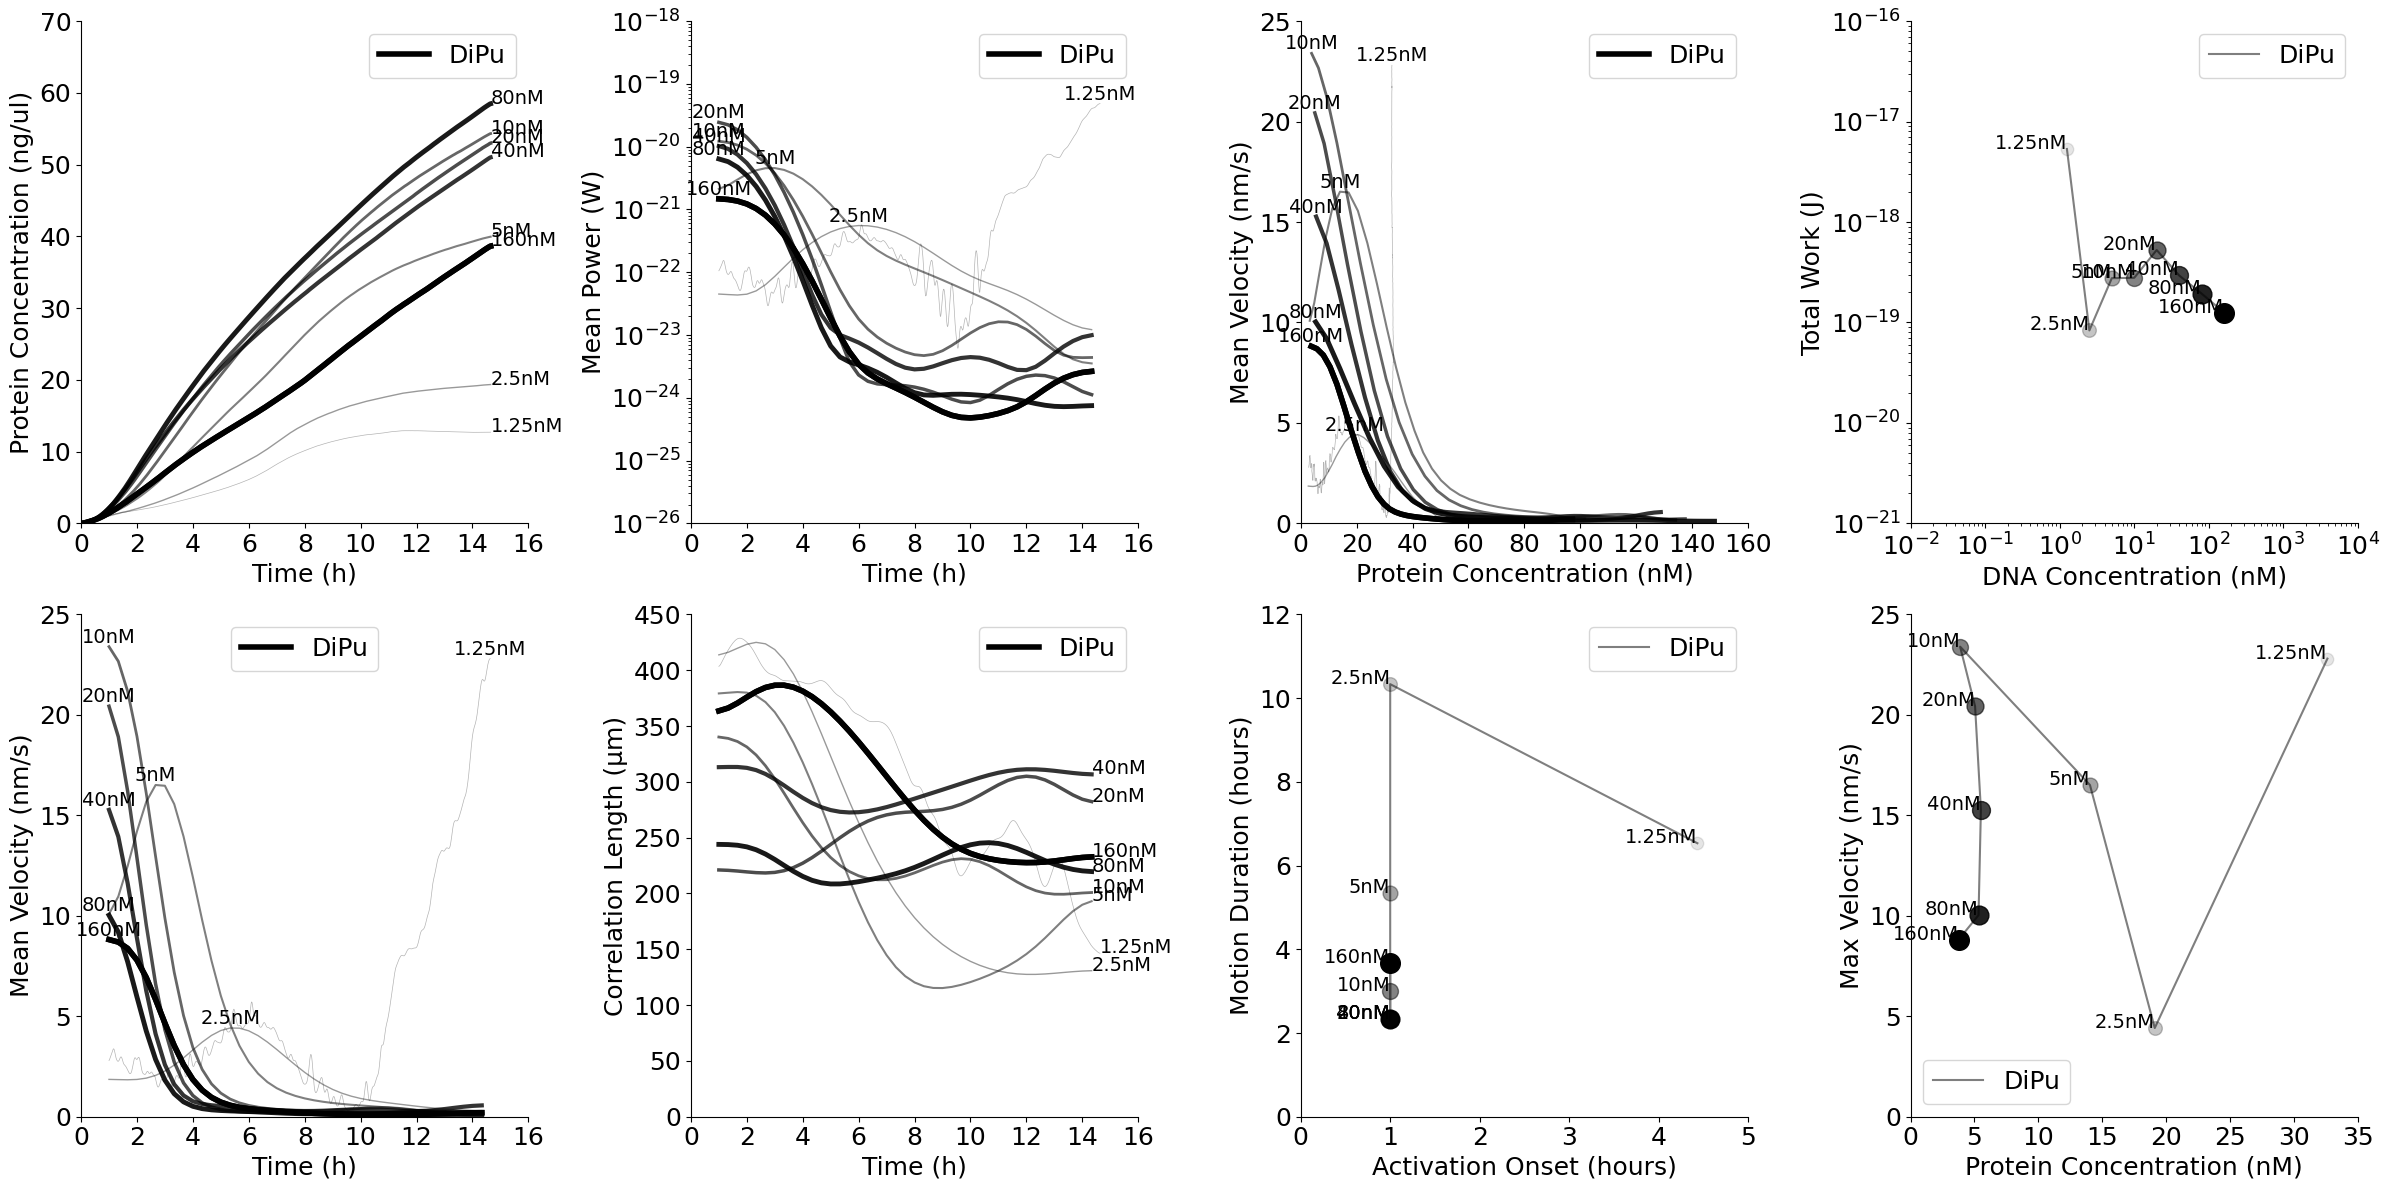

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

def generate_plots(df, protein_time_ranges, dna_concentrations, output_dir, velocity_threshold=0.2, time_unit='h', colored_DNAnM=True, combined_plots=False):
    """
    Generates plots for selected proteins based on the given parameters.

    Parameters:
    - df: DataFrame containing experimental data
    - protein_time_ranges: Dictionary with protein names as keys and time range tuples as values (in minutes)
    - dna_concentrations: List of DNA concentrations in nM to filter the data
    - output_dir: Directory to save the plots
    - time_unit: 'min' or 'h' for x-axis
    - colored_DNAnM: Boolean to determine if DNA concentration text should be colored according to protein
    - combined_plots: Boolean to determine if all plots should be outputted together in a 2x4 grid
    """
    
    # Define color map for proteins
    color_map = {
        'A': '#1f77b4', 'B': '#7f7f7f', 'C': '#2ca02c', 'D': '#d62728',
        'E': '#9467bd', 'F': '#8c564b', 'G': '#e377c2', 'H': '#ff7f0e',
        'A': '#1f77b4', 'B': '#7f7f7f', 'ThTr': '#2ca02c', 'AcSu2': '#d62728',
        'E': '#9467bd', 'F': '#8c564b', 'G': '#e377c2', 'H': '#ff7f0e'
    }
    
    # Determine time column
    time_col = 'Time_min' if time_unit == 'min' else 'Time_h'

    # Create output directory for the current DNA concentration and proteins
    proteins_str = '_'.join(protein_time_ranges.keys())
    dna_output_dir = os.path.join(output_dir, f'{proteins_str}_Combined_DNA')
    os.makedirs(dna_output_dir, exist_ok=True)

    # Define figure size for all plots
    fig_size = (6, 6)

    if combined_plots:
        fig, axes = plt.subplots(2, 4, figsize=(24, 12))
        axes = axes.flatten()
        plot_idx = 0

    def save_or_show_plot(plot_name):
        nonlocal plot_idx
        if combined_plots:
            axes[plot_idx].set_xlabel(plt.gca().get_xlabel(), fontsize=18)
            axes[plot_idx].set_ylabel(plt.gca().get_ylabel(), fontsize=18)
            axes[plot_idx].set_xticks(plt.gca().get_xticks())
            axes[plot_idx].set_yticks(plt.gca().get_yticks())
            axes[plot_idx].set_xlim(plt.gca().get_xlim())
            axes[plot_idx].set_ylim(plt.gca().get_ylim())
            axes[plot_idx].legend(fontsize=18)
            axes[plot_idx].spines['top'].set_visible(False)
            axes[plot_idx].spines['right'].set_visible(False)
            plot_idx += 1
        else:
            plt.tight_layout()
            plt.savefig(os.path.join(dna_output_dir, plot_name), dpi=500)
            plt.show()

    # Plot Protein Concentration vs. Time
    if combined_plots:
        plt.sca(axes[plot_idx])
    else:
        plt.figure(figsize=fig_size)
    for protein, time_range in protein_time_ranges.items():
        for i, dna_concentration in enumerate(sorted(dna_concentrations, reverse=True)):
            df_filtered = df[(df['DNA nM'] == str(dna_concentration)) & (df['protein'] == protein)]
            smoothed_concentration = gaussian_filter1d(df_filtered['Protein Concentration_nM'], sigma=3)
            alpha = 1.0 - (i * 0.1)
            linewidth = 4.0 - (i * 0.5)
            plt.plot(df_filtered['Time_h'], smoothed_concentration, 
                     color=color_map.get(protein, 'black'), alpha=alpha, linewidth=linewidth)
            # Add DNA concentration label at the right of the last data point
            if not df_filtered.empty:
                text_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                plt.text(df_filtered['Time_h'].iloc[-1], smoothed_concentration[-1], f'{dna_concentration}nM', fontsize=14, ha='left', color=text_color)
            if i == 0:
                plt.plot(df_filtered['Time_h'], smoothed_concentration, label=protein, 
                         color=color_map.get(protein, 'black'), alpha=alpha, linewidth=linewidth)

    plt.xlabel('Time (h)', fontsize=18)
    plt.ylabel('Protein Concentration (nM)', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.legend(fontsize=18)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    save_or_show_plot('Protein_Concentration_vs_Time.svg')

    # Plot Mean Power vs. Time
    if combined_plots:
        plt.sca(axes[plot_idx])
    else:
        plt.figure(figsize=fig_size)
    for protein, time_range in protein_time_ranges.items():
        for i, dna_concentration in enumerate(sorted(dna_concentrations, reverse=True)):
            df_filtered = df[(df['DNA nM'] == str(dna_concentration)) & (df['protein'] == protein)].dropna(subset=['power [W]_mean', time_col])
            if time_range and time_range != (None, None):
                df_filtered = df_filtered[(df_filtered['Time_min'] >= time_range[0]) & (df_filtered['Time_min'] <= time_range[1])]
            smoothed_power = gaussian_filter1d(df_filtered['power [W]_mean'], sigma=3)
            alpha = 1.0 - (i * 0.1)
            linewidth = 4.0 - (i * 0.5)
            plt.plot(df_filtered[time_col], smoothed_power, 
                     color=color_map.get(protein, 'black'), alpha=alpha, linewidth=linewidth)
            # Add DNA concentration label at the peak of the power
            if not df_filtered.empty:
                peak_power_idx = smoothed_power.argmax()
                peak_power_time = df_filtered[time_col].iloc[peak_power_idx]
                peak_power_value = smoothed_power[peak_power_idx]
                text_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                plt.text(peak_power_time, peak_power_value, f'{dna_concentration}nM', fontsize=14, ha='center', va='bottom', color=text_color)
            if i == 0:
                plt.plot(df_filtered[time_col], smoothed_power, label=protein, 
                         color=color_map.get(protein, 'black'), alpha=alpha, linewidth=linewidth)
    
    plt.xlabel(f'Time ({time_unit})', fontsize=18)
    plt.ylabel('Mean Power (W)', fontsize=18)
    plt.yscale('log')
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend(fontsize=18)
    save_or_show_plot('Mean_Power_vs_Time.svg')

    # Plot Mean Velocity vs. Protein Concentration
    if combined_plots:
        plt.sca(axes[plot_idx])
    else:
        plt.figure(figsize=fig_size)
    for protein, time_range in protein_time_ranges.items():
        for i, dna_concentration in enumerate(sorted(dna_concentrations, reverse=True)):
            df_filtered = df[(df['DNA nM'] == str(dna_concentration)) & (df['protein'] == protein)].dropna(subset=['velocity magnitude [m/s]_mean', 'Protein Concentration_nM'])
            if time_range and time_range != (None, None):
                df_filtered = df_filtered[(df_filtered['Time_min'] >= time_range[0]) & (df_filtered['Time_min'] <= time_range[1])]
            smoothed_velocity = gaussian_filter1d(df_filtered['velocity magnitude [m/s]_mean'] * 1e9, sigma=3)
            alpha = 1.0 - (i * 0.1)
            linewidth = 4.0 - (i * 0.5)
            plt.plot(df_filtered['Protein Concentration_nM'], smoothed_velocity, 
                     color=color_map.get(protein, 'black'), alpha=alpha, linewidth=linewidth)
            # Add DNA concentration label at the peak of the velocity
            if not df_filtered.empty:
                peak_velocity_idx = smoothed_velocity.argmax()
                peak_velocity_time = df_filtered['Protein Concentration_nM'].iloc[peak_velocity_idx]
                peak_velocity_value = smoothed_velocity[peak_velocity_idx]
                text_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                plt.text(peak_velocity_time, peak_velocity_value, f'{dna_concentration}nM', fontsize=14, ha='center', va='bottom', color=text_color)
            if i == 0:
                plt.plot(df_filtered['Protein Concentration_nM'], smoothed_velocity, label=protein, 
                         color=color_map.get(protein, 'black'), alpha=alpha, linewidth=linewidth)
    
    plt.xlabel('Protein Concentration (nM)', fontsize=18)
    plt.ylabel('Mean Velocity (nm/s)', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend(fontsize=18)
    save_or_show_plot('Mean_Velocity_vs_Protein_Concentration.svg')

    # Plot Total Work vs. DNA Concentration
    if combined_plots:
        plt.sca(axes[plot_idx])
    else:
        plt.figure(figsize=fig_size)
    for protein, time_range in protein_time_ranges.items():
        if protein in df['protein'].unique():
            protein_data = df[df['protein'] == protein]
            dna_concs, total_works = [], []

            for dna_conc in sorted(dna_concentrations, key=lambda x: float(x), reverse=True):
                data = protein_data[protein_data['DNA nM'] == str(dna_conc)]
                work_data = data['work [J]_mean'].dropna()
                if len(work_data) > 0:
                    dna_concs.append(float(dna_conc))
                    total_works.append(work_data.iloc[-1])

            alphas = np.linspace(1.0, 0.1, len(dna_concs))
            sizes = np.linspace(200, 80, len(dna_concs))
            for i, (x, y, alpha, size) in enumerate(zip(dna_concs, total_works, alphas, sizes)):
                plt.scatter(x, y, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
                text_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                plt.text(x, y, f'{x if x % 1 != 0 else int(x)}nM', fontsize=14, ha='right', color=text_color)  # Add DNA concentration labels
            plt.plot(dna_concs, total_works, color=color_map.get(protein, 'black'), alpha=0.5, label=protein)

    plt.xlabel('DNA Concentration (nM)', fontsize=18)
    plt.ylabel('Total Work (J)', fontsize=18)
    plt.yscale('log')
    plt.xticks(np.arange(0, max(dna_concs) + 40, 40), fontsize=18)
    plt.yticks(fontsize=18)
    plt.xscale('log')
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend(loc='lower right', fontsize=18)
    save_or_show_plot('Total_Work_vs_DNA_Concentration.svg')

    # Plot Mean Velocity vs. Time
    if combined_plots:
        plt.sca(axes[plot_idx])
    else:
        plt.figure(figsize=fig_size)
    for protein, time_range in protein_time_ranges.items():
        for i, dna_concentration in enumerate(sorted(dna_concentrations, reverse=True)):
            df_filtered = df[(df['DNA nM'] == str(dna_concentration)) & (df['protein'] == protein)].dropna(subset=['velocity magnitude [m/s]_mean', time_col])
            if time_range and time_range != (None, None):
                df_filtered = df_filtered[(df_filtered['Time_min'] >= time_range[0]) & (df_filtered['Time_min'] <= time_range[1])]
            smoothed_velocity = gaussian_filter1d(df_filtered['velocity magnitude [m/s]_mean'] * 1e9, sigma=3)
            alpha = 1.0 - (i * 0.1)
            linewidth = 4.0 - (i * 0.5)
            plt.plot(df_filtered[time_col], smoothed_velocity, 
                     color=color_map.get(protein, 'black'), alpha=alpha, linewidth=linewidth)
            # Add DNA concentration label at the peak of the velocity
            if not df_filtered.empty:
                peak_velocity_idx = smoothed_velocity.argmax()
                peak_velocity_time = df_filtered[time_col].iloc[peak_velocity_idx]
                peak_velocity_value = smoothed_velocity[peak_velocity_idx]
                text_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                plt.text(peak_velocity_time, peak_velocity_value, f'{dna_concentration}nM', fontsize=14, ha='center', va='bottom', color=text_color)
            if i == 0:
                plt.plot(df_filtered[time_col], smoothed_velocity, label=protein, 
                         color=color_map.get(protein, 'black'), alpha=alpha, linewidth=linewidth)

    plt.xlabel(f'Time ({time_unit})', fontsize=18)
    plt.ylabel('Mean Velocity (nm/s)', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.legend(fontsize=18)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    save_or_show_plot('Mean_Velocity_vs_Time.svg')

    # Plot Correlation Length vs. Time
    if combined_plots:
        plt.sca(axes[plot_idx])
    else:
        plt.figure(figsize=fig_size)
    for protein, time_range in protein_time_ranges.items():
        for i, dna_concentration in enumerate(sorted(dna_concentrations, reverse=True)):
            df_filtered = df[(df['DNA nM'] == str(dna_concentration)) & (df['protein'] == protein)].dropna(subset=['correlation length [m]_mean', time_col])
            if time_range and time_range != (None, None):
                df_filtered = df_filtered[(df_filtered['Time_min'] >= time_range[0]) & (df_filtered['Time_min'] <= time_range[1])]
            smoothed_correlation_length = gaussian_filter1d(df_filtered['correlation length [m]_mean'], sigma=3)
            alpha = 1.0 - (i * 0.1)
            linewidth = 4.0 - (i * 0.5)
            plt.plot(df_filtered[time_col], smoothed_correlation_length * 1e6, 
                     color=color_map.get(protein, 'black'), alpha=alpha, linewidth=linewidth)
            # Add DNA concentration label at the right of the last data point
            if not df_filtered.empty:
                text_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                plt.text(df_filtered[time_col].iloc[-1], smoothed_correlation_length[-1] * 1e6, f'{dna_concentration}nM', fontsize=14, ha='left', color=text_color)
            if i == 0:
                plt.plot(df_filtered[time_col], smoothed_correlation_length * 1e6, label=protein, 
                         color=color_map.get(protein, 'black'), alpha=alpha, linewidth=linewidth)
    
    plt.xlabel(f'Time ({time_unit})', fontsize=18)
    plt.ylabel('Correlation Length (µm)', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend(fontsize=18)
    save_or_show_plot('Correlation_Length_vs_Time.svg')

    # Plot Motion Duration vs. Activation Onset
    if combined_plots:
        plt.sca(axes[plot_idx])
    else:
        plt.figure(figsize=fig_size)
    max_motion_duration = 0  # Initialize a variable to track the maximum motion duration
    for protein, time_range in protein_time_ranges.items():
        motion_durations = []
        activation_onsets = []
        dna_labels = []
        for dna_conc in sorted(dna_concentrations, key=lambda x: float(x), reverse=True):
            df_protein = df[(df['protein'] == protein) & (df['DNA nM'] == str(dna_conc))].dropna(subset=['velocity magnitude [m/s]_mean', time_col])
            if time_range and time_range != (None, None):
                df_protein = df_protein[(df_protein['Time_min'] >= time_range[0]) & (df_protein['Time_min'] <= time_range[1])]
            
            # Apply Gaussian filter with sigma=3
            smoothed_velocity = gaussian_filter1d(df_protein['velocity magnitude [m/s]_mean'], sigma=3)
            df_protein['smoothed_velocity'] = smoothed_velocity
            
            peak_velocity = df_protein['smoothed_velocity'].max()
            threshold_velocity = velocity_threshold * peak_velocity  # 40% of peak velocity
            above_threshold = df_protein[df_protein['smoothed_velocity'] >= threshold_velocity]
            if not above_threshold.empty:
                activation_onset = above_threshold[time_col].iloc[0]  # Time where velocity first surpasses threshold
                motion_duration = above_threshold[time_col].count() * (df_protein[time_col].diff().mean())  # Cumulative time
                activation_onsets.append(activation_onset)
                motion_durations.append(motion_duration)
                dna_labels.append(f'{dna_conc}nM')
                max_motion_duration = max(max_motion_duration, motion_duration)  # Update max motion duration
        
        if motion_durations:
            alphas = np.linspace(1.0, 0.1, len(motion_durations))
            sizes = np.linspace(200, 80, len(motion_durations))
            for i, (x, y, alpha, size, label) in enumerate(zip(activation_onsets, motion_durations, alphas, sizes, dna_labels)):
                plt.scatter(x, y, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
                text_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                plt.text(x, y, label, fontsize=14, ha='right', color=text_color)
            plt.plot(activation_onsets, motion_durations, color=color_map.get(protein, 'black'), alpha=0.5, label=protein)

    # Determine the x-axis label based on the time unit
    if time_unit == 'min':
        plt.xlabel('Activation Onset (minutes)', fontsize=18)
        plt.ylabel('Motion Duration (minutes)', fontsize=18)
    else:
        plt.xlabel('Activation Onset (hours)', fontsize=18)
        plt.ylabel('Motion Duration (hours)', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlim(left=0)
    plt.ylim(bottom=0, top=max_motion_duration + 1)  # Set y-axis limit to 1 hour more than the top motion duration
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend(fontsize=18)
    save_or_show_plot('Motion_Duration_vs_Activation_Onset.svg')

    # Plot Max Velocity vs. Protein Concentration
    if combined_plots:
        plt.sca(axes[plot_idx])
    else:
        plt.figure(figsize=fig_size)
    for protein, time_range in protein_time_ranges.items():
        max_velocities = []
        protein_concs = []
        dna_labels = []  # To store DNA concentration labels
        for dna_concentration in sorted(dna_concentrations, reverse=True):
            df_filtered = df[(df['DNA nM'] == str(dna_concentration)) & (df['protein'] == protein)].dropna(subset=['velocity magnitude [m/s]_mean', 'Protein Concentration_nM'])
            if time_range and time_range != (None, None):
                df_filtered = df_filtered[(df_filtered['Time_min'] >= time_range[0]) & (df_filtered['Time_min'] <= time_range[1])]
            smoothed_velocity = gaussian_filter1d(df_filtered['velocity magnitude [m/s]_mean'] * 1e9, sigma=3)
            if not df_filtered.empty:
                peak_velocity_idx = smoothed_velocity.argmax()
                peak_velocity_value = smoothed_velocity[peak_velocity_idx]
                protein_conc_at_peak = df_filtered['Protein Concentration_nM'].iloc[peak_velocity_idx]
                max_velocities.append(peak_velocity_value)
                protein_concs.append(protein_conc_at_peak)
                # Format DNA concentration label
                if float(dna_concentration).is_integer():
                    dna_labels.append(f'{int(dna_concentration)}nM')
                else:
                    dna_labels.append(f'{dna_concentration}nM')
        
        if max_velocities:
            alphas = np.linspace(1.0, 0.1, len(max_velocities))
            sizes = np.linspace(200, 80, len(max_velocities))
            for i, (x, y, alpha, size, label) in enumerate(zip(protein_concs, max_velocities, alphas, sizes, dna_labels)):
                plt.scatter(x, y, color=color_map.get(protein, 'black'), s=size, alpha=alpha)
                text_color = color_map.get(protein, 'black') if colored_DNAnM else 'black'
                plt.text(x, y, label, fontsize=14, ha='right', color=text_color)
            plt.plot(protein_concs, max_velocities, color=color_map.get(protein, 'black'), alpha=0.5, label=protein)

    plt.xlabel('Protein Concentration (nM)', fontsize=18)
    plt.ylabel('Max Velocity (nm/s)', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend(fontsize=18)
    save_or_show_plot('Max_Velocity_vs_Protein_Concentration.svg')

    if combined_plots:
        plt.tight_layout()
        plt.savefig(os.path.join(dna_output_dir, 'Combined_Plots.svg'), dpi=500)
        plt.show()

# Example usage:
protein_time_ranges = {
    # 'AcSu2': (30, 60*28), 
    # 'ThTr': (20, 60*40)
    'DiPu': (60, 60*16), 
}  # Time ranges in minutes

titrations = [160 / (2 ** i) for i in range(11)]
titrations = [int(t) if t.is_integer() else t for t in titrations][:8:]
print(titrations)

generate_plots(df, protein_time_ranges, dna_concentrations=titrations, output_dir='../../../Downloads/Selected_Proteins_Plots', velocity_threshold=0.15, time_unit='h', colored_DNAnM=True, combined_plots=True)
